# CIFAR‑10 with a Fully Connected Neural Network

**Lab 2: CIFAR‑10 Classification with a Fully Connected Neural Network**

**Weighting (Total 5%)**
- **In‑Lab (3 hours)** — *2%*: train a simple feedforward NN on CIFAR‑10, plot **training vs validation loss/accuracy**, compute a **confusion matrix**, and inspect **misclassifications**.
- **Take‑Home (1 week)** — *3%*: try small modifications (hidden size / activation / LR / epochs), update plots & metrics, and write a short 1–2 page report.

**Learning goals**
- Get comfortable with a new dataset (**CIFAR‑10**, 32×32 color images).
- Practice evaluating models beyond accuracy: curves, confusion matrix, qualitative errors.
- See limits of fully connected NNs on images (CNNs will follow in the next lab).

In [9]:
# ✅ Device setup (CPU/GPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Importing some required libraries. You can add more if needed.

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## PART A: In lab

1. Load the CIFAR-10 dataset. Load, normalize, create train/val/test splits. The trainset is shown for you.

100%|██████████| 170M/170M [01:42<00:00, 1.67MB/s]


Train size: 50000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


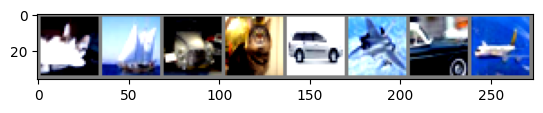

cat ship car cat car plane car plane


In [ ]:
# Transform: convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),                           # convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5),            # mean for R,G,B
                         (0.5, 0.5, 0.5))            # std for R,G,B
])

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])


root = './data'
val_size = 5000
batch_size=256

full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

# ----- Test dataset -----
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

test_ds = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)

# DataLoader for validation and test
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Train DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print("Train size:", len(full_train))


# Class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Helper function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize back to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


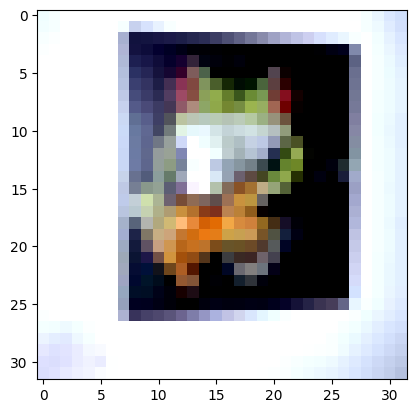

frog
Shape of one class instance:  torch.Size([3, 32, 32])


In [ ]:
# Let's see how our data looks into our train set (Not required for the assignment)
img, label = train_ds[4]

imshow(img)
print(classes[label])
print("Shape of one class instance: ", img.shape)

2. Implement a fully connected FFNN (no CNN). Train for a few epochs.


In [12]:
class FFNN(nn.Module):
    def __init__(self, hidden=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, hidden)      # 3072 -> hidden
        self.fc2 = nn.Linear(hidden, hidden//2)    # hidden -> hidden/2
        self.fc3 = nn.Linear(hidden//2, 10)        # hidden/2 -> 10 classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)         # [B, 3, 32, 32] -> [B, 3072]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model = FFNN(hidden=512).to(device)

criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----- Track metrics -----
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/6, Train Loss: 1.7694, Train Acc: 37.11%, Val Loss: 1.5898, Val Acc: 44.50%
Epoch 2/6, Train Loss: 1.5994, Train Acc: 43.30%, Val Loss: 1.4980, Val Acc: 47.22%
Epoch 3/6, Train Loss: 1.5185, Train Acc: 46.39%, Val Loss: 1.4487, Val Acc: 48.94%
Epoch 4/6, Train Loss: 1.4652, Train Acc: 48.02%, Val Loss: 1.4296, Val Acc: 50.06%
Epoch 5/6, Train Loss: 1.4217, Train Acc: 49.52%, Val Loss: 1.4159, Val Acc: 50.98%
Epoch 6/6, Train Loss: 1.3897, Train Acc: 50.62%, Val Loss: 1.3815, Val Acc: 52.08%


3. Plot training vs validation loss and accuracy.


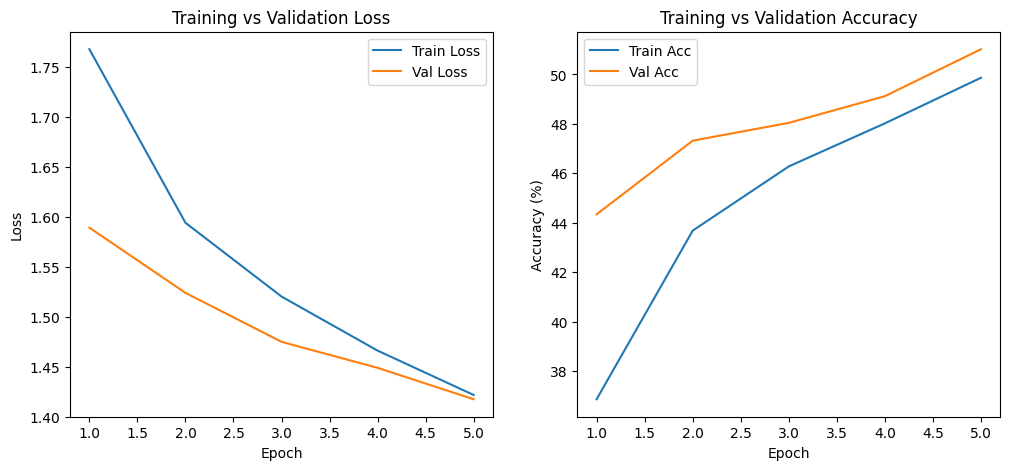

In [ ]:
# ----- Plot Loss -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ----- Plot Accuracy -----
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Acc")
plt.plot(range(1, epochs+1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


4. Compute a confusion matrix on the validation set.


[[272  20  21  28  13   6  11  35  56  34]
 [ 17 297  10  19   7   4  20  16  17 104]
 [ 48  11 178  64  52  43  49  52  11   8]
 [ 16   7  23 210  25  71  70  35  13  21]
 [ 35   7  68  51 186  23  75  53  13   8]
 [  6   8  35 162  18 137  51  47  13   8]
 [ 11   5  41  72  43  19 281  15   4   9]
 [ 15   7  14  39  40  20  13 291   7  20]
 [ 67  47   1  14   7   5   7   5 303  64]
 [ 21  68   8  20   4   5  18  21  13 318]]


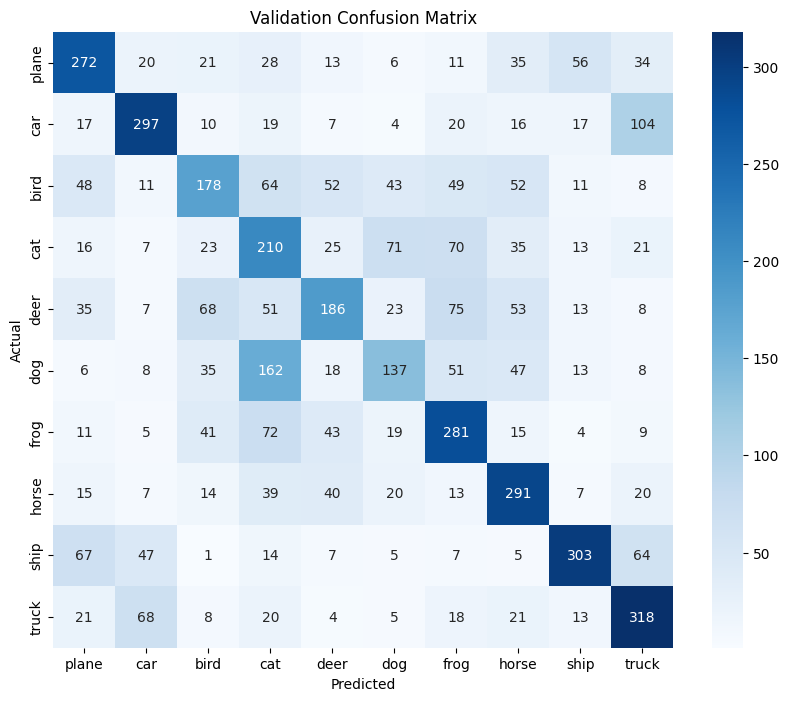

In [ ]:
# ----- Collect all predictions and labels -----
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ----- Compute confusion matrix -----
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# ----- Plot confusion matrix -----
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()


5. Display a grid of misclassified examples with predicted vs true labels.


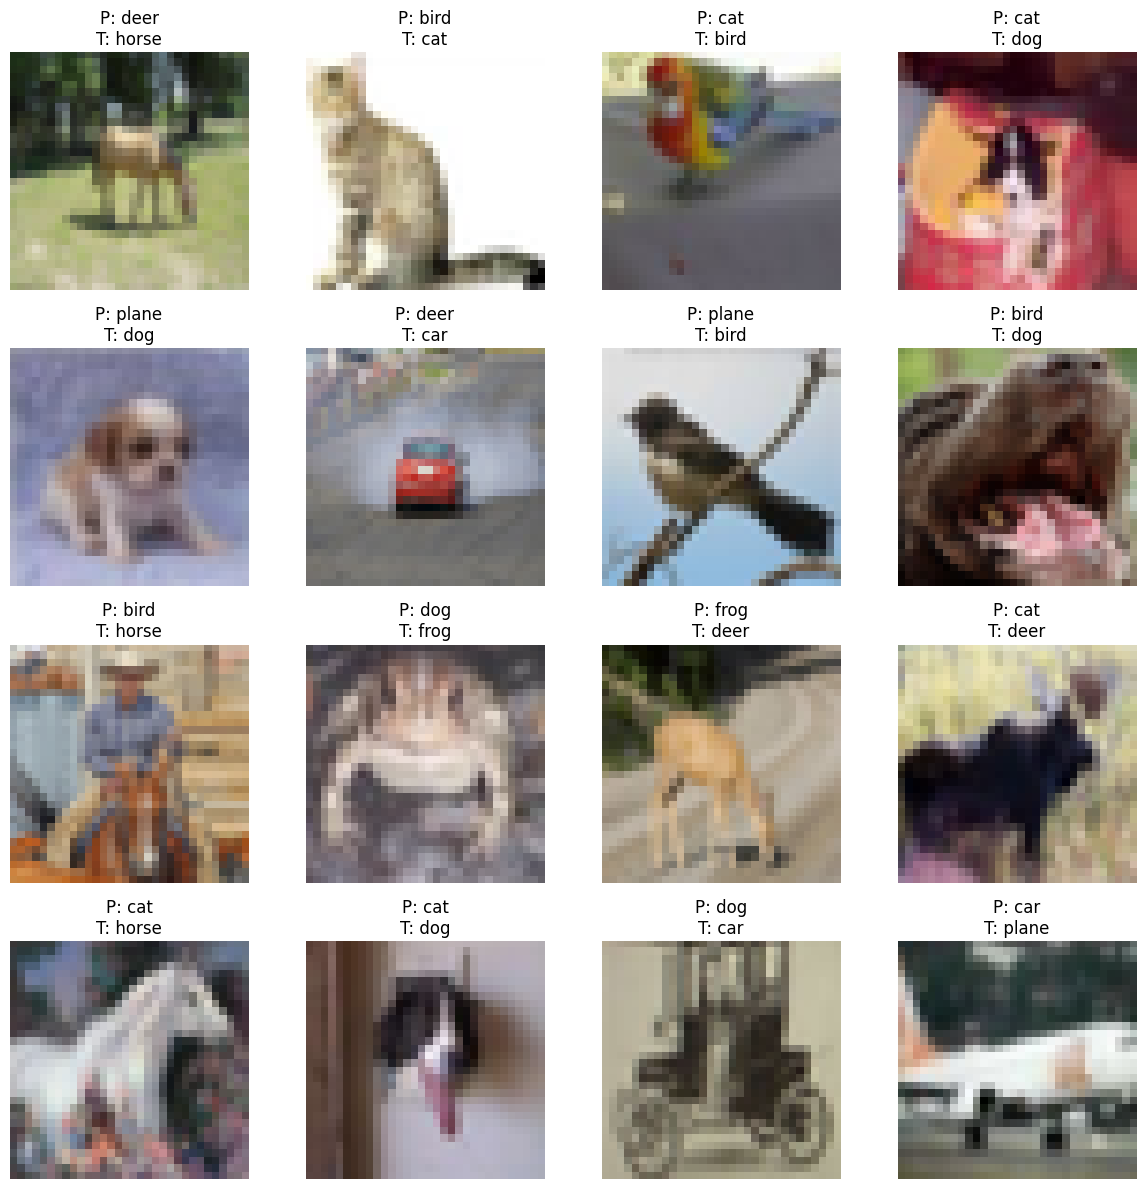

In [ ]:
# ----- Collect misclassified examples -----
misclassified_imgs = []
misclassified_preds = []
misclassified_labels = []

model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        # Find misclassified indices
        mask = predicted != target
        if mask.sum() > 0:
            misclassified_imgs.extend(data[mask].cpu())
            misclassified_preds.extend(predicted[mask].cpu())
            misclassified_labels.extend(target[mask].cpu())

# ----- Display a grid of misclassified examples -----
num_to_show = 16  # change as desired
plt.figure(figsize=(12, 12))

for i in range(num_to_show):
    plt.subplot(4, 4, i+1)
    img = misclassified_imgs[i]
    img = img * torch.tensor(cifar_std).view(3,1,1) + torch.tensor(cifar_mean).view(3,1,1)  # unnormalize
    img = np.clip(img.numpy().transpose(1,2,0), 0, 1)
    plt.imshow(img)
    plt.title(f"P: {classes[misclassified_preds[i]]}\nT: {classes[misclassified_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## PART B: Take Home

1. Make one or two changes to your hidden size / activation / learning rate / epochs


In [ ]:
model = FFNN(hidden=1024).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----- Track metrics -----
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 8
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/8, Train Loss: 1.7471, Train Acc: 38.17%, Val Loss: 1.6019, Val Acc: 43.40%
Epoch 2/8, Train Loss: 1.5743, Train Acc: 44.29%, Val Loss: 1.5052, Val Acc: 47.34%
Epoch 3/8, Train Loss: 1.4998, Train Acc: 47.09%, Val Loss: 1.4588, Val Acc: 48.10%
Epoch 4/8, Train Loss: 1.4442, Train Acc: 48.86%, Val Loss: 1.4499, Val Acc: 49.66%
Epoch 5/8, Train Loss: 1.4000, Train Acc: 50.31%, Val Loss: 1.4436, Val Acc: 49.80%
Epoch 6/8, Train Loss: 1.3610, Train Acc: 51.48%, Val Loss: 1.3955, Val Acc: 52.08%
Epoch 7/8, Train Loss: 1.3196, Train Acc: 53.18%, Val Loss: 1.3967, Val Acc: 51.86%
Epoch 8/8, Train Loss: 1.2827, Train Acc: 54.14%, Val Loss: 1.3976, Val Acc: 51.14%


2. Re‑train and update plots & validation metrics.

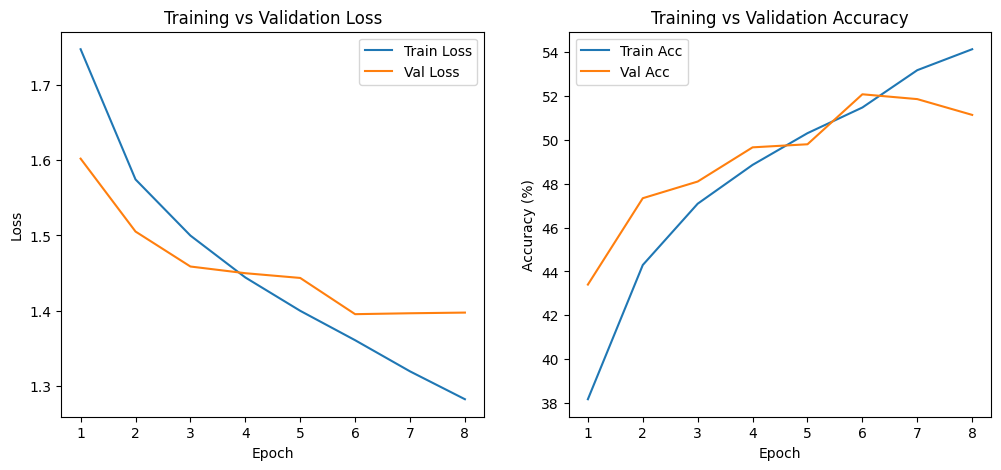

In [ ]:
# ----- Plot Loss -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# ----- Plot Accuracy -----
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Acc")
plt.plot(range(1, epochs+1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()

3. Write a 1–2 page PDF discussing training dynamics, confusion trends, and effect of your changes. DONT FORGET TO SUBMIT PDF.